In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from questionnaire_scoring import (
    pdc_get_timepoint_1,
    process_questionnaire
    )
from data_functions import (
    convert_df_type,
    scaling, 
    pca_permulation,
    merge_dataframes,
    scaled_data,
    impute_group_median,
    determine_number_of_clusters,
    fit_pca,
    clustering

)
import numpy as np

from factor_analysis import data_fit, create_loading_design_matrix, model_fit_parameters, cfa_model, obtain_correlation_values
from sklearn.cluster import KMeans
import seaborn as sns
sns.set_style('dark')
from data_dictionaries_for_subjects import banda_questions, ep_questions, pdc_questions, get_columns_from_dictionary, pdc_questions_orginal, banda_questions_orginal, score_rcads

In [6]:
base_dir = os.path.join(os.environ['HOME'], 'data', 'HCP-disease', 'behavioural')
banda_part = pd.read_csv("sub_ids/banda_id.csv")
banda_key = pd.read_csv(os.path.join(base_dir, 'BANDA', 'tmp', 'BANDAinfocomplete.csv'))
banda_key['ALL_Data'] = banda_key['ALL_Data'].str.replace('_MR','')
banda_key = banda_key[['ALL_Data', 'phenotype', 'sex','interview_age']].rename(columns={"ALL_Data": "id"})
band_particpant_info = pd.merge(banda_key, banda_part, left_on='id', right_on='part', how='right').drop('part', axis=1)
banda_df = pd.read_excel(os.path.join(base_dir, 'BANDA', 'BehaviouralFiles.xlsx'), sheet_name=None)

,collection_id,stai01_id,dataset_id,subjectkey,src_subject_id,interview_date,interview_age,sex,stai1,stai2,...,stai_state18_i,stai_state19_i,stai_trait2_i,stai_trait3_i,stai_trait5_i,stai_trait11_i,stai_trait14_i,stai_trait15_i,collection_title,Study
0,collection_id,stai01_id,dataset_id,The NDAR Global Unique Identifier (GUID) for r...,Subject ID how it's defined in lab/project,Date on which the interview/genetic test/sampl...,Age in months at the time of the interview/tes...,Sex of subject at birth,Right now. I feel calm.,Right now. I feel secure,...,Right now. I feel overexcited and rattled.,Right now. I feel joyful.,Generally. I tire quickly.,Generally. I feel like crying.,Generally. I am losing out on things because I...,Generally. I am inclined to take things hard.,Generally. I try to avoid facing a crisis or d...,Generally. I feel blue.,collection_title,HCP_Study_Name
1,3037,110894,25763,NDAR_INVMU899TB3,BANDA001,2016-10-01,184,F,4,4,...,1,2,1,2,1,2,3,2,Connectomes Related to Anxiety and Depression ...,BANDA
2,3037,110895,25763,NDAR_INVPZ149TM8,BANDA002,2016-10-15,169,F,4,4,...,1,2,1,2,1,2,1,1,Connectomes Related to Anxiety and Depression ...,BANDA
3,3037,110896,25763,NDAR_INVVT290YVL,BANDA003,2016-11-09,177,M,4,4,...,1,4,1,1,1,1,4,1,Connectomes Related to Anxiety and Depression ...,BANDA
4,3037,110897,25763,NDAR_INVNV393FY3,BANDA004,2016-11-11,188,M,4,4,...,1,2,1,2,1,2,4,1,Connectomes Related to Anxiety and Depression ...,BANDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,3037,216687,56715,NDAR_INVMC515NMJ,BANDA208,2020-06-20,181,M,3,4,...,1,3,3,3,2,1,3,2,Connectomes Related to Anxiety and Depression ...,BANDA
1285,3037,216689,56715,NDAR_INVEX380KWX,BANDA210,2020-07-15,205,M,4,4,...,1,4,2,3,1,1,2,1,Connectomes Related to Anxiety and Depression ...,BANDA
1286,3037,216690,56715,NDAR_INVYK765MXP,BANDA211,2020-10-07,210,F,3,4,...,1,2,3,3,1,1,3,2,Connectomes Related to Anxiety and Depression ...,BANDA
1287,3037,216691,56715,NDAR_INVKL383VH7,BANDA212,2020-10-14,198,F,2,3,...,1,2,3,3,1,4,4,1,Connectomes Related to Anxiety and Depression ...,BANDA


In [24]:
pdc_key = pd.read_excel(os.path.join(base_dir, 'pdc', 'DemographicFiles.xlsx'))[1:]
pdc_key = pdc_key[['src_subject_id', 'phenotype', 'sex', 'interview_age']]
pdc_key['phenotype'] = pdc_key['phenotype'].str.replace('CONTROL', 'Control').str.replace('TSD Control', 'Control').str.replace("TSD MDD", "MDD").str.replace('HEALTHY', '').str.lstrip()
pdc_key['src_subject_id'] = pdc_key['src_subject_id'].str.lstrip()
pdc_particpant_info = pdc_key.rename(columns={"src_subject_id": "id"})
pdc_df = pd.read_excel(os.path.join(base_dir, 'PDC', 'BehaviouralFiles.xlsx'), sheet_name=None)

In [25]:
ep_df = pd.read_excel(os.path.join(base_dir, 'EP', 'BehaviouralFiles.xlsx'), sheet_name=None)
ep_key = pd.read_csv(os.path.join(base_dir, 'EP', 'tmp', 'EPinfocomplete.csv'))
ep_key_part = pd.read_csv("sub_ids/ep_id.csv")
ep_key = ep_key[['imgkey', 'interview_age',	'sex', 'phenotype']]
ep_key['imgkey'] = ep_key['imgkey'].str.replace('_01_MR', '').str.lstrip().astype("int")
ep_key['phenotype'] = ep_key['phenotype'].str.replace('Patient', 'early_psychosis').str.lstrip()
ep_key = ep_key.rename(columns={'imgkey': 'id'})
ep_particpant_info = pd.merge(left=ep_key, right=ep_key_part, left_on='id', right_on='part',  how='right').drop('part', axis=1)

In [ ]:
banda_questions = banda_questions_orginal
banda_df_keys = get_columns_from_dictionary(banda_questions)
pdc_df_keys = get_columns_from_dictionary(pdc_questions)
ep_df_keys = get_columns_from_dictionary(ep_questions)

In [27]:
ep_particpant_info = ep_particpant_info[ep_particpant_info['phenotype'] != 'Control']

In [28]:
def get_ep_data(df, participant_info):
    df['src_subject_id'] = df['src_subject_id'].astype("int64")
    return pd.merge(df, participant_info[['id', 'phenotype']], 
                    left_on='src_subject_id', 
                    right_on='id', 
                    how='right').drop('src_subject_id', axis=1)

In [29]:
panns_ep = get_ep_data(ep_df['panss01'][1:], ep_particpant_info)[['id', 'phenotype'] + ep_df_keys['panss01']]
yms_ep = get_ep_data(ep_df['ymrs01'][1:], ep_particpant_info)[['id', 'phenotype'] + ep_df_keys['ymrs01']]
madrs_ep = get_ep_data(ep_df['madrs01'][1:], ep_particpant_info)[['id', 'phenotype'] + ep_df_keys['madrs01']]
preda_ep = get_ep_data(ep_df['preda01'][1:][['src_subject_id'] + ep_df_keys['preda01']].dropna(), ep_particpant_info)[['id', 'phenotype'] + ep_df_keys['preda01']]
panns_ep = panns_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
yms_ep = yms_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
madrs_ep = madrs_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
preda_ep = preda_ep.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
ep_scores = merge_dataframes([
    panns_ep,
    yms_ep,
    madrs_ep, 
    preda_ep, 
    ep_particpant_info[['id', 'phenotype']]
    ])

In [31]:
ep_loadings_dict = {}
for phenotype in ep_questions.keys():
    ep_loadings_dict[phenotype] =  list({key for subdict in ep_questions[phenotype].values() for key in subdict})
ep_loadings_dict['psychosis'] = [val for val in ep_loadings_dict['psychosis'] if val not in ['neg_n1', 'neg_n6', 'neg_n7', 'neg_n1', 'gps_g10']]
ep_loadings_dict['anxiety'] = [val for val in ep_loadings_dict['anxiety'] if val not in ['sleepamt', 'madrsten', 'gps_g2' , 'gps_g4' ]]
ep_loadings_dict['depression'] = [val for val in ep_loadings_dict['depression'] if val not in ['gps_g6', 'eddep29', 'eddep17', 'eddep31', 'eddep54', 'eddep04', 'eddep41', 'eddep26', 'eddep06', 'eddep36', 'gps_g11', 'neg_n5']]
#pdc_loadings_dict['mood'] = pdc_loadings_dict['anxiety'] + pdc_loadings_dict['depression'] + ['bissc_total']#, 'bas_drive', 'bas_fs', 'bas_rr']
ep_columns = ep_loadings_dict['anxiety'] +  ep_loadings_dict['depression'] + ep_loadings_dict['psychosis']


In [33]:
ep_data_fit = data_fit(ep_scores[ep_columns]) #convert_df_type(ep_scores[ep_columns]))
print(ep_data_fit['kmo_all'].describe())
print("\nfactors possibly not suitable: ")
not_suitable = ep_data_fit['kmo_all'].where(ep_data_fit['kmo_all'] <0.7).stack()
print(not_suitable)
print('\nmodel kmo', ep_data_fit['kmo_model'])
print('\nbartlett pval', ep_data_fit['bartlett_pval'])
print('\nbart chi2',ep_data_fit['bartlett_chi2'])

       KMO Score
count  35.000000
mean    0.632376
std     0.136965
min     0.312721
25%     0.537007
50%     0.663029
75%     0.748520
max     0.878125

factors possibly not suitable: 
sexinter  KMO Score    0.502694
neg_n2    KMO Score    0.673155
madrsfee  KMO Score    0.666419
gps_g7    KMO Score    0.545281
sexinter  KMO Score    0.502694
madrssui  KMO Score    0.686635
neg_n4    KMO Score    0.528734
sleepamt  KMO Score    0.398607
madrsapp  KMO Score    0.564809
madrsslp  KMO Score    0.488202
gps_g13   KMO Score    0.599565
pos_p4    KMO Score    0.413481
pos_p2    KMO Score    0.565395
pos_p1    KMO Score    0.663029
pos_p3    KMO Score    0.603440
gps_g5    KMO Score    0.312721
gps_g9    KMO Score    0.574311
neg_n3    KMO Score    0.573229
pos_p5    KMO Score    0.565369
pos_p7    KMO Score    0.455742
langdisr  KMO Score    0.500732
dtype: float64

model kmo 0.6496060074084967

bartlett pval nan

bart chi2 nan


In [34]:
obtain_correlation_values(ep_scores[ep_columns], 0.8)

Series([], dtype: float64)

In [35]:
ep_matrix = create_loading_design_matrix(ep_loadings_dict, ep_columns)

In [36]:
det_corr = np.linalg.det(ep_scores[ep_columns].corr())
print(f"Determinant of correlation matrix: {det_corr}")   

Determinant of correlation matrix: -3.338044252221069e-41


<Axes: >

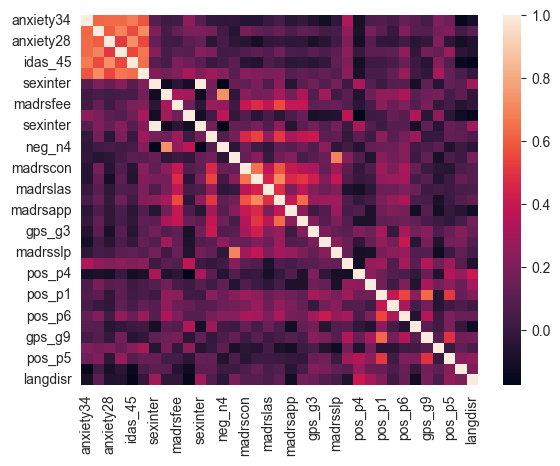

In [37]:
sns.heatmap(ep_scores[ep_columns].corr()) 

In [38]:
ep_scaled = scaled_data(ep_scores[ep_columns])
ep_model = cfa_model(ep_matrix, ep_scaled, len(ep_loadings_dict.keys()), len(ep_columns), [key for key in ep_loadings_dict.keys()])

In [39]:
fit = model_fit_parameters(ep_model, ep_scaled, cols=ep_columns)
loading_df = fit['loadings'].rename(index={1: 'anxiety', 0: 'depression', 2: 'Psychosis'})
display(loading_df)
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,anxiety34,idas_16,anxiety28,anxiety24,idas_45,idas_56,sexinter,neg_n2,madrsfee,gps_g7,...,pos_p2,pos_p1,pos_p3,pos_p6,gps_g5,gps_g9,neg_n3,pos_p5,pos_p7,langdisr
depression,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.177327,0.338722,0.59087,0.035666,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
anxiety,0.78835,0.820011,0.75366,0.782354,0.787158,0.812035,0.179515,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Psychosis,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.299756,0.867498,0.363376,0.585269,0.190403,0.717349,0.022602,0.594913,0.224635,0.265925


'rmse 0.11647167503834659'

'mse 0.014784765629968435'

In [40]:
filtered = loading_df.apply(lambda x: x.where((x != 0) & (x < 0.7))).stack()
filtered

depression  sexinter    0.177327
            neg_n2      0.338722
            madrsfee    0.590870
            gps_g7      0.035666
            madrssui    0.604075
            neg_n4      0.162630
            sleepamt    0.236662
            madrslas    0.530939
            madrsapp    0.495215
            madrsaps    0.629908
            gps_g3      0.403538
            gps_g16     0.281347
            madrsslp    0.394944
anxiety     sexinter    0.179515
Psychosis   gps_g13     0.387513
            pos_p4      0.229179
            pos_p2      0.299756
            pos_p3      0.363376
            pos_p6      0.585269
            gps_g5      0.190403
            neg_n3      0.022602
            pos_p5      0.594913
            pos_p7      0.224635
            langdisr    0.265925
dtype: float64

In [41]:
ep_data = pd.concat([ep_particpant_info[['id', 'phenotype', 'interview_age', 'sex']].reset_index(drop=True), 
                        pd.DataFrame(ep_model.fit_transform(ep_scaled)).rename(columns={0: "Anxiety", 1:"Depression", 2: "Psychosis"
                                                                                          })], axis=1)

In [42]:
ep_data[['Anxiety', 'Depression', 'Psychosis']].corr()

,Anxiety,Depression,Psychosis
Anxiety,1.000000,0.115610,0.293046
Depression,0.115610,1.000000,0.130652
Psychosis,0.293046,0.130652,1.000000


<Axes: >

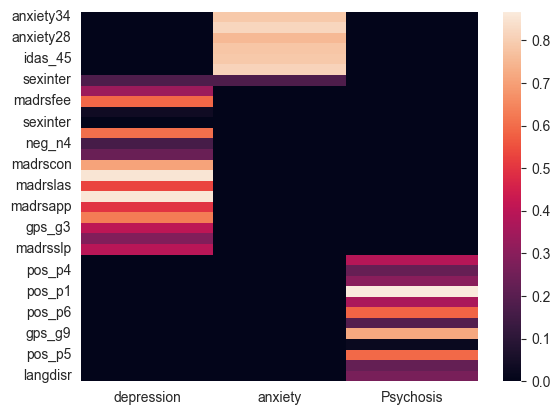

In [43]:
sns.heatmap(loading_df.T)

## PDC

In [44]:
pdc_df['apath01']

,collection_id,apath01_id,dataset_id,subjectkey,src_subject_id,interview_date,interview_age,sex,apath_01,apath_02,...,apath_13,apath_14,apath_15,apath_16,apath_17,apath_18,apath_19,collection_title,src_subject_id_mod,Study
0,collection_id,apath01_id,dataset_id,The NDAR Global Unique Identifier (GUID) for r...,Subject ID how it's defined in lab/project,Date on which the interview/genetic test/sampl...,Age in months at the time of the interview/tes...,Sex of subject at birth,I am interested in things,I get things done during the day,...,I am less concerned about my problems than I s...,I have friends,Getting together with friends is important to me,"When something good happens, I get excited",I have an accurate understanding of my problems,I have initiative,Apathy Evaluation Scale total score,collection_title,Subject ID how it's defined in lab/project,HCP_Study_Name
1,2844,546,47531,NDAR_INVBD367YU9,k_0004,03/01/2017,659,M,2,3,...,1,2,2,2,3,3,49,Perturbation of the treatment resistant depres...,k0004,PDC
2,2844,547,47531,NDAR_INVBD367YU9,k_0004,03/07/2017,659,M,2,3,...,1,2,2,2,3,2,51,Perturbation of the treatment resistant depres...,k0004,PDC
3,2844,548,47531,NDAR_INVBD367YU9,k_0004,03/14/2017,659,M,2,3,...,1,2,2,2,3,2,48,Perturbation of the treatment resistant depres...,k0004,PDC
4,2844,549,47531,NDAR_INVBD367YU9,k_0004,04/18/2017,660,M,2,3,...,1,2,4,3,3,3,35,Perturbation of the treatment resistant depres...,k0004,PDC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,2844,1073,47531,NDARBU379ZD7,h_0063,12/03/2019,401,M,4,4,...,4,4,4,4,4,4,27,Perturbation of the treatment resistant depres...,h0063,PDC
510,2844,1074,47531,NDARBU379ZD7,h_0063,12/18/2019,401,M,4,4,...,4,4,4,4,4,4,27,Perturbation of the treatment resistant depres...,h0063,PDC
511,2844,1075,47531,NDARBK372GFE,h_0064,01/17/2020,289,F,4,4,...,2,3,3,4,4,4,26,Perturbation of the treatment resistant depres...,h0064,PDC
512,2844,1076,47531,NDARBK372GFE,h_0064,01/31/2020,289,F,4,4,...,2,3,3,3,3,4,28,Perturbation of the treatment resistant depres...,h0064,PDC


In [45]:
apath_pdc = pdc_get_timepoint_1(pdc_df['apath01'], pdc_particpant_info)[['id', 'phenotype', 'apath_19']]
shaps_pdc = pdc_get_timepoint_1(pdc_df['shaps01'], pdc_particpant_info)[['id', 'phenotype'] + pdc_df_keys['shaps01'] ]
hrsd_pdc = pdc_get_timepoint_1(pdc_df['hrsd01'], pdc_particpant_info)[['id', 'phenotype'] + pdc_df_keys['hrsd01']]
bids_pdc = pdc_get_timepoint_1(pdc_df['bisbas01'], pdc_particpant_info)[['id', 'phenotype', 'bissc_total', 'bas_drive', 'bas_fs', 'bas_rr']]
bids_pdc = bids_pdc.replace('999', np.nan) 
qids_pdc = pdc_get_timepoint_1(pdc_df['qids01'], pdc_particpant_info)[['id', 'phenotype'] + pdc_df_keys['qids01']]
dass_pdc = pdc_get_timepoint_1(pdc_df['dass01'], pdc_particpant_info)[['id', 'phenotype'] + pdc_df_keys['dass01']]
dass_pdc = dass_pdc.replace('999', np.nan) 

In [46]:
apath_pdc = apath_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
shaps_pdc = shaps_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
hrsd_pdc = hrsd_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
bids_pdc = bids_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
qids_pdc = qids_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
dass_pdc = dass_pdc.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
pdc_scores = merge_dataframes([
    apath_pdc,
    shaps_pdc,
    hrsd_pdc, 
    bids_pdc, 
    qids_pdc, 
    dass_pdc,
    pdc_particpant_info[['id', 'phenotype']]
    ])

In [47]:
pdc_loadings_dict = {}
for phenotype in pdc_questions.keys():
    pdc_loadings_dict[phenotype] =  list({key for subdict in pdc_questions[phenotype].values() for key in subdict})
pdc_loadings_dict['anxiety'] = pdc_loadings_dict['anxiety'] + ['bissc_total']
pdc_loadings_dict['depression'] = pdc_loadings_dict['depression'] + ['apath_19']
#pdc_loadings_dict['mood'] = pdc_loadings_dict['anxiety'] + pdc_loadings_dict['depression'] + ['bissc_total']#, 'bas_drive', 'bas_fs', 'bas_rr']
pdc_columns = pdc_loadings_dict['anxiety'] +  pdc_loadings_dict['depression'] + pdc_loadings_dict['psychosis']


In [50]:
pdc_data_fit = data_fit(convert_df_type(pdc_scores[pdc_columns_filtered]))
print(pdc_data_fit['kmo_all'].describe())
print("\nfactors possibly not suitable: ")
not_suitable = pdc_data_fit['kmo_all'].where(pdc_data_fit['kmo_all'] <0.7).stack()
print(not_suitable)
print('\nmodel kmo', pdc_data_fit['kmo_model'])
print('\nbartlett pval', pdc_data_fit['bartlett_pval'])
print('\nbart chi2',pdc_data_fit['bartlett_chi2'])

       KMO Score
count  44.000000
mean    0.912633
std     0.058234
min     0.684965
25%     0.905532
50%     0.934238
75%     0.949244
max     0.965677

factors possibly not suitable: 
vapdc  KMO Score    0.684965
dtype: float64

model kmo 0.92711257167947

bartlett pval 0.0

bart chi2 8002.916450080994


In [66]:
not_suitable_vals = [not_suitable.index[col][0] for col, _ in enumerate(not_suitable.index)] + ['apath_01', 'apath_09', 'apath_06', 'apath_15', 'apath_18', 'apath_17', 'apath_07', 'apath_04', 'apath_16', 'apath_12', 'apath_10', 'apath_14', 'apath_08', 'apath_03', 'apath_13', 'apath_02', 'apath_05', 'apath_11', 'shaps11', 'shaps12', 'shaps5', 'hslow', 'happt'] #['shaps11', 'shaps12', 'shaps5', 'apath_05', 'apath_09', 'apath_18', 'apath_17', 'apath_04', 'apath_03'] + ['hsuic', 'hmdsd', 'hslow', 'vengy', 'apath_12', 'happt', 'vslow', 'apath_10', 'vapdc', 'vsuic', 'hengy', 'vmdsd', 'bissc_total', 'hsanx',  'hagit']
pdc_columns_filtered = [val for val in pdc_columns if val not in not_suitable_vals] 

In [67]:
obtain_correlation_values(pdc_scores[pdc_columns_filtered], 0.8)

Series([], dtype: float64)

In [68]:
for key in pdc_loadings_dict.keys():  
   pdc_loadings_dict[key] = [val for val in pdc_loadings_dict[key] if val not in not_suitable_vals]

In [69]:
pdc_matrix = create_loading_design_matrix(pdc_loadings_dict, pdc_columns_filtered)

In [70]:
det_corr = np.linalg.det(pdc_scores[pdc_columns_filtered].corr())
print(f"Determinant of correlation matrix: {det_corr}")   

Determinant of correlation matrix: 6.432654734482236e-15


<Axes: >

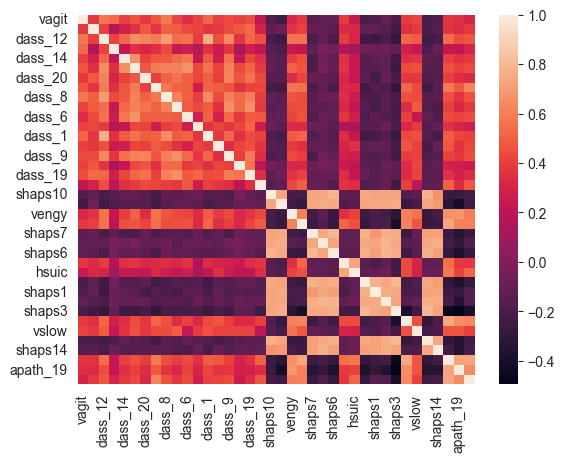

In [71]:
sns.heatmap(pdc_scores[pdc_columns_filtered].corr())  

In [72]:
groupsby = pdc_scores.groupby('phenotype')
control = groupsby.get_group("Control")
control = scaled_data(control[pdc_columns_filtered])
mdd = groupsby.get_group("MDD")
mdd = scaled_data(mdd[pdc_columns_filtered])

In [73]:
pdc_scaled = pd.DataFrame(np.vstack([control, mdd]))
pdc_model = cfa_model(pdc_matrix, pdc_scaled, len(pdc_loadings_dict.keys()), len(pdc_columns_filtered), [key for key in pdc_loadings_dict.keys()])

In [74]:
fit = model_fit_parameters(pdc_model, pdc_scaled, cols=pdc_columns_filtered)
loading_df = fit['loadings'].rename(index={1: 'anxiety', 0: 'depression', 2: "psychosis"})
display(loading_df)
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,vagit,dass_7,dass_12,hagit,dass_14,dass_11,dass_20,hpanx,dass_8,dass_15,...,shaps1,shaps8,shaps3,hengy,vslow,shaps4,shaps14,hmdsd,apath_19,hvwsf
depression,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.703018,0.806833,0.735908,-0.163408,-0.128395,0.734591,0.706127,-0.254428,-0.469952,0.000000
anxiety,0.45336,0.41833,0.672932,0.353419,0.596619,0.715827,0.706266,0.533323,0.778204,0.757521,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
psychosis,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.781818


'rmse 0.0964578464397049'

'mse 0.010847865816348806'

In [ ]:
hslow happt

In [75]:
filtered_neg = loading_df.apply(lambda x: x.where((x < 0))).stack()
filtered_neg

depression  vengy      -0.213143
            vmdsd      -0.243857
            vsuic      -0.114757
            hsuic      -0.065683
            hengy      -0.163408
            vslow      -0.128395
            hmdsd      -0.254428
            apath_19   -0.469952
dtype: float64

In [76]:
filtered = loading_df.apply(lambda x: x.where((x != 0) & (x < 0.4))).stack()
filtered

depression  vengy         -0.213143
            vmdsd         -0.243857
            vsuic         -0.114757
            hsuic         -0.065683
            hengy         -0.163408
            vslow         -0.128395
            hmdsd         -0.254428
            apath_19      -0.469952
anxiety     hagit          0.353419
            hsanx          0.395805
            bissc_total    0.369660
dtype: float64

In [77]:
pdc_data = pd.concat([pdc_particpant_info[['id', 'phenotype', 'interview_age', 'sex']].reset_index(drop=True), 
                        pd.DataFrame(pdc_model.fit_transform(pdc_scaled)).rename(columns={0: "Anxiety", 1:"Depression", 2: "Psychosis"
                                                                                          })], axis=1)

In [78]:
pdc_data[['Anxiety', 'Depression', "Psychosis"]].corr()

,Anxiety,Depression,Psychosis
Anxiety,1.000000,-0.166218,-0.180772
Depression,-0.166218,1.000000,0.402256
Psychosis,-0.180772,0.402256,1.000000


In [7]:
sns.heatmap(pdc_data[['Anxiety', 'Depression', 'Psychosis']].corr()
)

NameError: name 'pdc_data' is not defined

<Axes: >

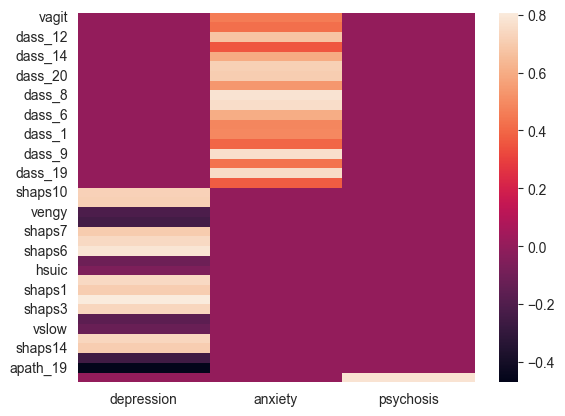

In [80]:
correlation_matrix = pd.concat([pdc_scores[pdc_columns_filtered], pdc_data[['Anxiety', 'Depression']]], axis=1).corr()
sns.heatmap(loading_df.T)

## BANDA symptoms

In [14]:
stai_banda = process_questionnaire( banda_df["stai01"], band_particpant_info, 'stai01_id')[[ 'id', 'phenotype'] + banda_df_keys['stai01']]
shaps_banda = process_questionnaire(banda_df["shaps01"], band_particpant_info, 'shaps01_id')[['id', 'phenotype']+ banda_df_keys['shaps01']]
mfg_banda = process_questionnaire(banda_df['mfq01'], band_particpant_info, 'mfq01_id')[['id', 'phenotype']+ banda_df_keys['mfq01']]
#nffi_banda = process_questionnaire(banda_df['nffi01'], band_particpant_info, 'nffi01_id')[['id', 'phenotype']+ banda_df_keys['nffi01']]
cbcl_banda = process_questionnaire(banda_df["cbcl01"], band_particpant_info, 'cbcl01_id')[['id', 'phenotype']+ banda_df_keys['cbcl01']]
#masq_banda = process_questionnaire(banda_df['masq01'], band_particpant_info, 'masq01_id')[['id', 'phenotype']+ banda_df_keys['masq01']]
#cssrs_banda = process_questionnaire(banda_df['cssrs01'], band_particpant_info, 'cssrs01_id')[['id', 'phenotype']+ banda_df_keys['cssrs01']]


In [15]:
rcads_banda = score_rcads(banda_df['rcads01'])#.drop(["internalising", "anxiety"], axis=1)
rcads_banda = pd.merge(rcads_banda, band_particpant_info, on="id", how="left")


In [16]:
rcads_banda = rcads_banda.groupby("phenotype", group_keys=False).apply(impute_group_median).drop(["phenotype", "sex", "interview_age"], axis=1)
stai_banda = stai_banda.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
shaps_banda = shaps_banda.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
mfg_banda = mfg_banda.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
#nffi_banda = nffi_banda.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
cbcl_banda = cbcl_banda.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
#masq_banda = masq_banda.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)
#cssrs_banda = cssrs_banda.groupby("phenotype", group_keys=False).apply(impute_group_median).drop("phenotype", axis=1)

In [17]:
stai_banda

,id,stai_state4_i,stai36,stai30,stai_state8_i,stai_trait3_i,stai2,stai38,stai12,stai26,...,stai5,stai13,stai_state14_i,stai11,stai15,stai29,stai_state19_i,stai_trait14_i,stai16,stai3
0,BANDA001,2.0,2.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,...,4.0,2.0,1.0,2.0,4.0,3.0,2.0,3.0,3.0,1.0
1,BANDA002,1.0,4.0,4.0,2.0,2.0,4.0,1.0,1.0,1.0,...,4.0,1.0,1.0,4.0,4.0,1.0,2.0,1.0,4.0,1.0
2,BANDA003,1.0,4.0,4.0,3.0,1.0,4.0,1.0,1.0,4.0,...,4.0,1.0,1.0,4.0,4.0,1.0,4.0,4.0,4.0,1.0
3,BANDA004,1.0,4.0,4.0,4.0,2.0,4.0,2.0,2.0,3.0,...,4.0,1.0,1.0,4.0,4.0,1.0,2.0,4.0,4.0,1.0
4,BANDA005,1.0,3.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,...,3.0,1.0,1.0,4.0,3.0,1.0,3.0,2.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,BANDA210,2.0,4.0,4.0,2.0,1.0,4.0,2.0,4.0,3.0,...,3.0,2.0,2.0,3.0,3.0,3.0,2.0,2.0,4.0,3.0
198,BANDA211,3.0,3.0,3.0,1.0,3.0,3.0,2.0,2.0,3.0,...,2.0,4.0,4.0,4.0,2.0,4.0,2.0,2.0,2.0,4.0
199,BANDA212,4.0,3.0,3.0,1.0,4.0,3.0,4.0,4.0,2.0,...,3.0,4.0,4.0,2.0,3.0,4.0,1.0,3.0,2.0,3.0
200,BANDA213,1.0,2.0,2.0,1.0,4.0,3.0,4.0,4.0,2.0,...,3.0,4.0,2.0,2.0,3.0,4.0,1.0,1.0,3.0,4.0


In [84]:
merged_df = merge_dataframes([
    rcads_banda,
    stai_banda,
    shaps_banda,
    mfg_banda,
    cbcl_banda])
banda_df_scored = pd.merge(band_particpant_info, merged_df, how='outer')

In [85]:
grouping = banda_df_scored.groupby("phenotype")
transformed_final = {}
for group_id in grouping.groups.keys():
    df = grouping.get_group(group_id)
    for col in df.columns[4:]:
         mean_value = df[col].median(skipna=True)
         df.loc[df[col].isna(), col] = mean_value
         transformed_final[group_id] = df

In [86]:
banda_df_scored = pd.concat([transformed_final['Control'], transformed_final['Anxiety'], transformed_final['Depression']]).sort_values("id")

In [87]:
banda_loadings_dict = {}
for phenotype in banda_questions.keys():
    banda_loadings_dict[phenotype] =  list({key for subdict in banda_questions[phenotype].values() for key in subdict})
banda_loadings_dict['anxiety'] = banda_loadings_dict['anxiety']
banda_loadings_dict['depression'] = banda_loadings_dict['depression']
banda_columns = banda_loadings_dict['anxiety'] +  banda_loadings_dict['depression'] + banda_loadings_dict['psychosis']


In [88]:
banda_data_fit = data_fit(convert_df_type(banda_df_scored[banda_columns]))
print(banda_data_fit['kmo_all'].describe())
print("\nfactors possibly not suitable: ")
not_suitable = banda_data_fit['kmo_all'].where(banda_data_fit['kmo_all'] <0.7).stack()
print(not_suitable)
print('\nmodel kmo', banda_data_fit['kmo_model'])
print('\nbartlett pval', banda_data_fit['bartlett_pval'])
print('\nbart chi2',banda_data_fit['bartlett_chi2'])

       KMO Score
count  92.000000
mean    0.877499
std     0.093199
min     0.500958
25%     0.841584
50%     0.919486
75%     0.939657
max     0.960431

factors possibly not suitable: 
stai_state18_i  KMO Score    0.500958
shaps6          KMO Score    0.625102
shaps8          KMO Score    0.672617
shaps14         KMO Score    0.635361
cbcl85          KMO Score    0.687285
cbcl84          KMO Score    0.658722
dtype: float64

model kmo 0.9120980616603787

bartlett pval 0.0

bart chi2 15748.100863929529


In [89]:
#[not_suitable.index[col][0] for col, _ in enumerate(not_suitable.index)] +
not_suitable_vals =  ['cbcl68', 'cbcl84', 'cbcl40'] + ['mfqc1_3', 'mfqc1_4', 'mfqc2_1', 'mfqc2_4', 'mfqc2_5', 'mfqc3_1', 'mfqc3_5', 'mfqc5_1', 'mfqc5_5', 'mfqc6_1', 'mfqc6_4', 'mfqc6_3']
banda_columns_filtered = [val for val in banda_columns if val not in not_suitable_vals] 

In [90]:
obtain_correlation_values(banda_df_scored[banda_columns_filtered], 0.8)

Series([], dtype: float64)

In [91]:
for key in banda_loadings_dict.keys():  
   banda_loadings_dict[key] = [val for val in banda_loadings_dict[key] if val not in not_suitable_vals]

In [92]:
banda_matrix = create_loading_design_matrix(banda_loadings_dict, banda_columns_filtered)

In [93]:
groupsby = banda_df_scored.groupby('phenotype')
control = groupsby.get_group("Control")
control = scaled_data(control[banda_columns_filtered])
axniety = groupsby.get_group("Anxiety")
axniety = scaled_data(axniety[banda_columns_filtered])
depression = groupsby.get_group("Depression")
depression = scaled_data(depression[banda_columns_filtered])

In [94]:
banda_scaled = pd.DataFrame(np.vstack([control, axniety, depression]))
banda_model = cfa_model(banda_matrix, banda_scaled, len(banda_loadings_dict.keys()), len(banda_columns_filtered), [key for key in banda_loadings_dict.keys()])

In [95]:
fit = model_fit_parameters(banda_model, banda_scaled, cols=banda_columns_filtered)
load_df = fit['loadings'].rename(index={0:"Depression", 1: "Anxiety", 2: "Psychosis"})
display(load_df)
display(f"rmse {fit['rmse']}")
display(f"mse {fit['mse']}")

,stai38,stai_state4_i,stai_trait3_i,stai1,stai29,stai_trait5_i,stai28,stai_state19_i,stai16,stai36,...,mfqc2_2,mfqc4_2,mfqc4_6,shaps4,shaps14,mfqc5_2,mfqc3_6,shaps9,cbcl85,cbcl70
Depression,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.284165,0.913886,1.162007,0.881676,0.703493,0.809265,0.990268,0.810436,0.000000,0.000000
Anxiety,1.073929,0.966026,0.811194,0.885946,1.091069,0.925417,1.024995,0.899774,0.989956,0.905479,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Psychosis,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.844323,0.840513


'rmse 0.6061019840394952'

'mse 0.3832594712923378'

<Axes: >

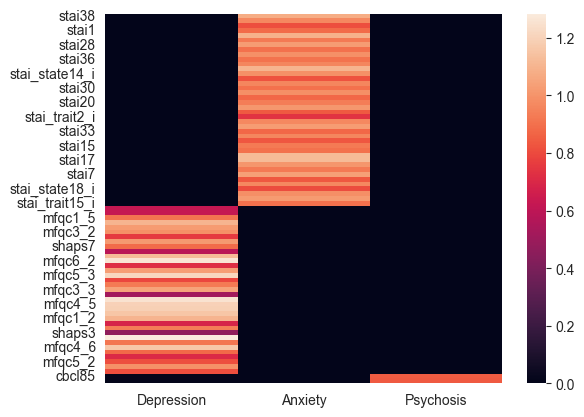

In [96]:
sns.heatmap(load_df.T)

In [97]:
load_df.apply(lambda x: x.where((x < 0))).stack()

Series([], dtype: float64)

In [98]:
filtered = load_df.apply(lambda x: x.where((x != 0) & (x < 0.4))).stack()
filtered

Series([], dtype: float64)

In [99]:
banda_data = pd.concat([banda_df_scored[['id', 'phenotype', 'interview_age', 'sex']], 
                        pd.DataFrame(banda_model.fit_transform(banda_df_scored[banda_columns_filtered].values)).rename(columns={0: "Anxiety", 1:"Depression", 2: "Psychosis"})], axis=1)

In [100]:
banda_data[["Anxiety", "Depression", "Psychosis"]].corr()

,Anxiety,Depression,Psychosis
Anxiety,1.000000,-0.385230,-0.087763
Depression,-0.385230,1.000000,0.045828
Psychosis,-0.087763,0.045828,1.000000


<Axes: >

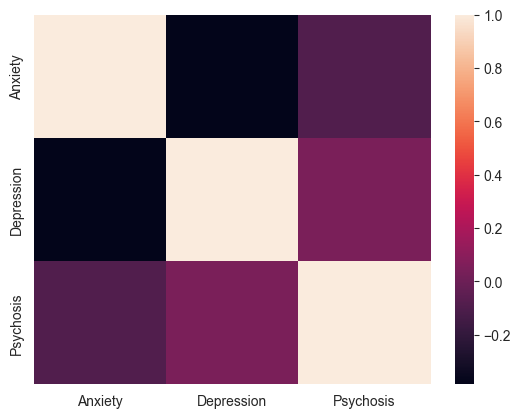

In [101]:
sns.heatmap(banda_data[["Anxiety", "Depression", "Psychosis"]].corr())

In [102]:
clustering_df = pd.concat([pdc_data, ep_data, banda_data])

In [113]:
clustering_df['zscore_anxiety'] = (clustering_df["Anxiety"] - clustering_df["Anxiety"].mean()) / clustering_df["Anxiety"].std()
clustering_df['zscore_depression'] = (clustering_df["Depression"] - clustering_df["Depression"].mean()) / clustering_df["Depression"].std()
clustering_df['zscore_psychosis'] = (clustering_df["Psychosis"] - clustering_df["Psychosis"].mean()) / clustering_df["Psychosis"].std()

In [ ]:
clustering_df[clustering_df['zscore_psychosis'].abs() > 3].index.to_list()

,id,phenotype,interview_age,sex,Anxiety,Depression,Psychosis,zscore_anxiety,zscore_depression,zscore_psychosis
25,k_0066,MDD,540,M,-0.031497,6.489400,8.953490,-0.036635,7.908202,8.370447
51,k_0155,MDD,680,F,-2.212276,1.539683,4.258643,-2.573181,1.876310,3.981325
22,BANDA024,Depression,189,M,-0.346595,0.063304,4.216112,-0.403137,0.077144,3.941563
53,BANDA055,Anxiety,179,F,-0.178629,-0.022089,4.216112,-0.207770,-0.026919,3.941563
66,BANDA068,Depression,186,F,0.051575,0.027651,4.216112,0.059989,0.033697,3.941563
102,BANDA105,Control,201,F,0.242633,-0.047220,4.216112,0.282215,-0.057544,3.941563
149,BANDA154,Anxiety,204,M,-0.430454,0.018834,4.216112,-0.500678,0.022951,3.941563


In [125]:
to_drop = clustering_df[clustering_df['zscore_anxiety'].abs() > 3].index.to_list() + clustering_df[clustering_df['zscore_depression'].abs() > 3].index.to_list()

In [130]:
clustering_df[['id', 'phenotype' , 'Anxiety', 'Depression']].drop(index=to_drop)

,id,phenotype,Anxiety,Depression
0,k_0004,MDD,0.352003,-0.515448
1,k_0008,MDD,0.119998,0.142413
2,k_0009,MDD,0.007472,-0.534879
3,k_0010,MDD,-0.446026,0.307368
4,k_0011,MDD,0.474814,-0.359458
...,...,...,...,...
198,BANDA210,Anxiety,0.737394,-0.022731
199,BANDA211,Depression,0.753960,0.007779
200,BANDA212,Depression,0.155964,0.017548
201,BANDA213,Depression,0.087103,0.010418


<Axes: >

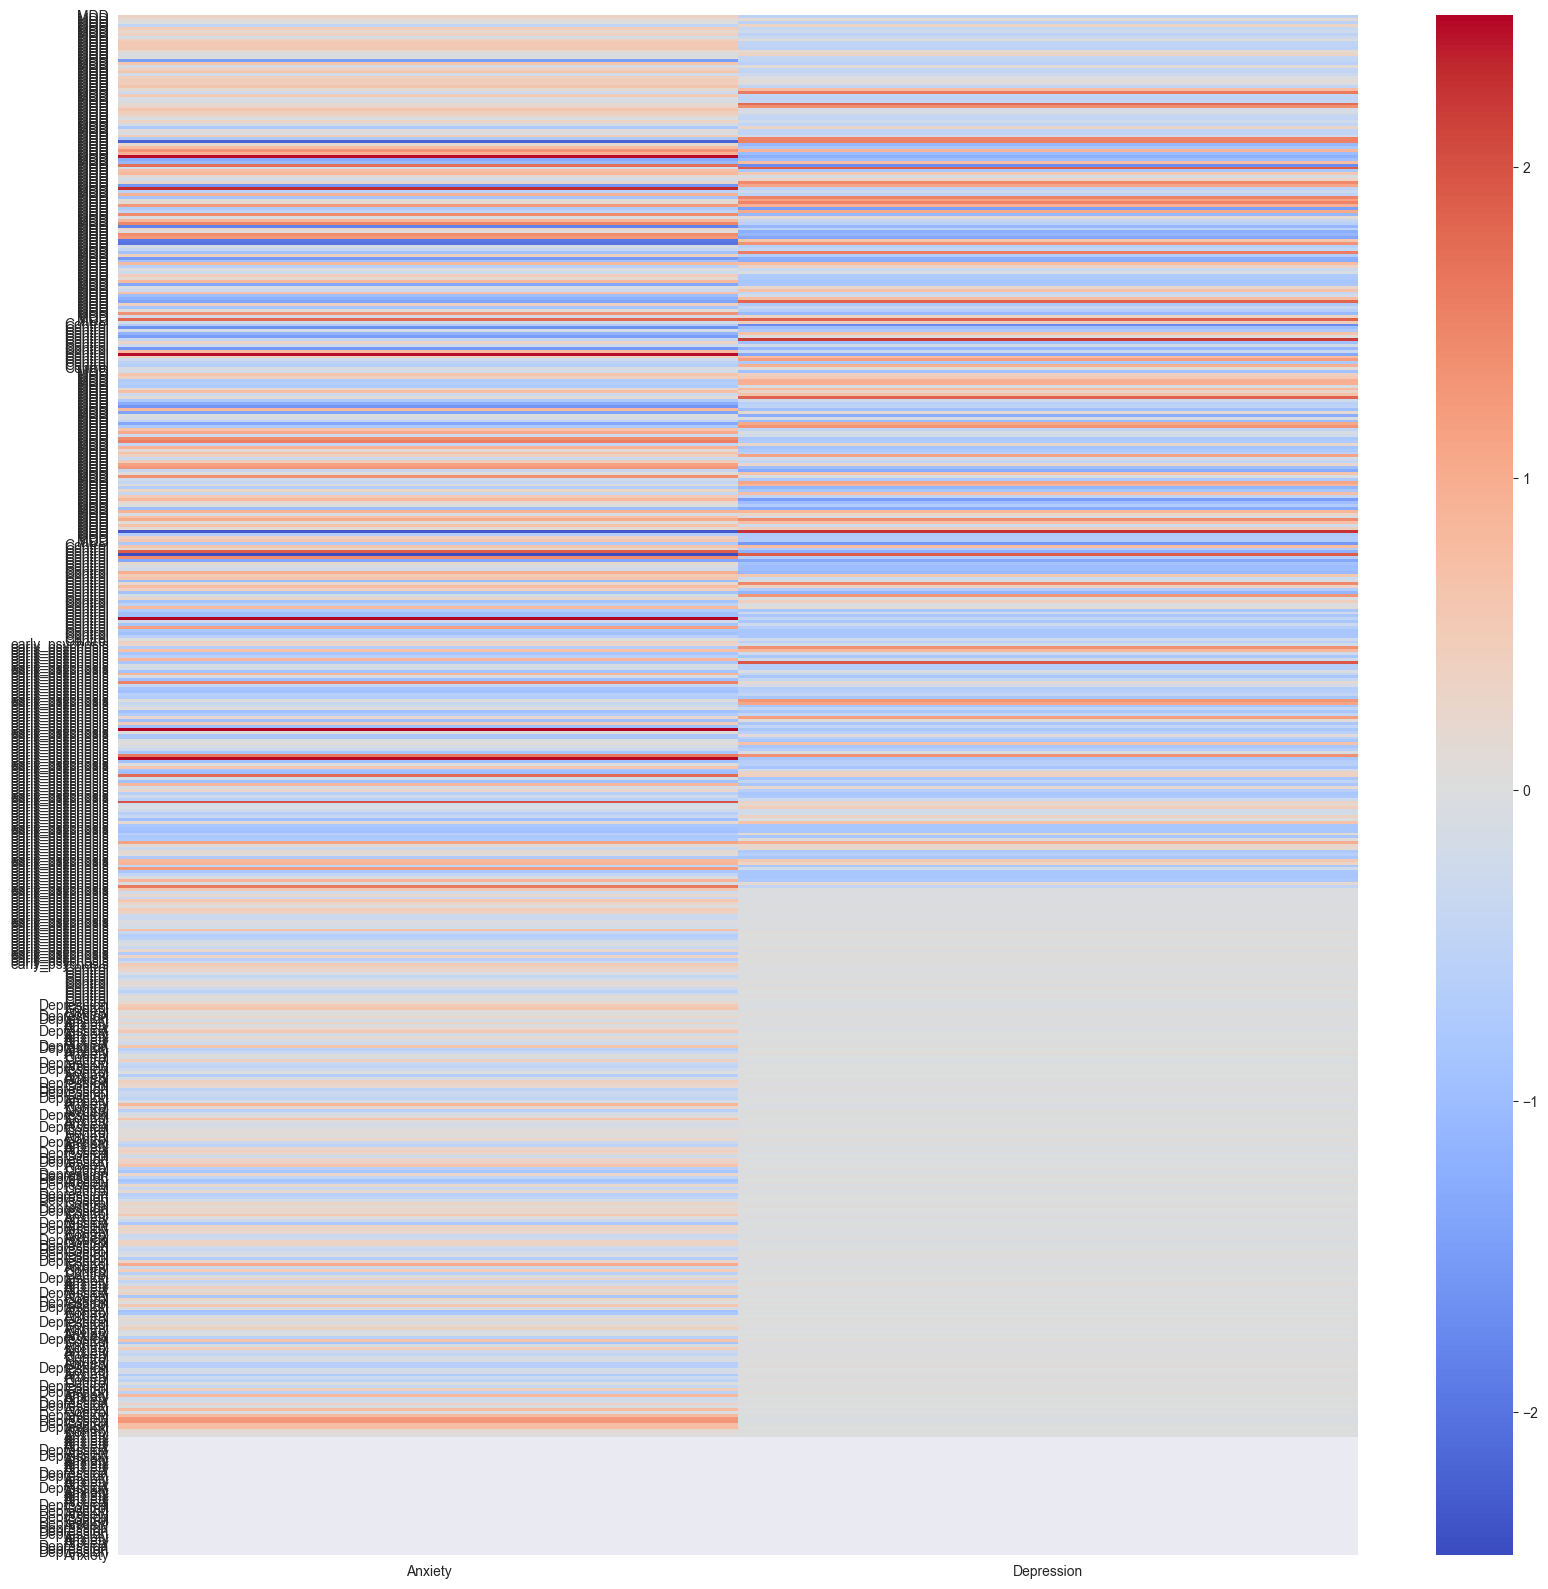

In [148]:
plt.figure(figsize=(20,20))
sns.heatmap(clustering_df[['Anxiety', 'Depression']].drop(index=to_drop), yticklabels=clustering_df['phenotype'], cmap='coolwarm', annot=False, annot_kws={"size": 8})

In [24]:
banda_data

,id,phenotype,interview_age,sex,Anxiety,Depression,2
0,BANDA001,Control,184,F,0.091791,-0.676148,-1.054186
1,BANDA002,Control,169,F,-0.061515,2.657988,-1.054186
2,BANDA003,Control,177,M,-0.055416,2.573908,-1.054186
3,BANDA004,Control,188,M,0.131465,2.603204,-1.054186
4,BANDA005,Control,191,M,0.155583,0.941668,-1.054186
...,...,...,...,...,...,...,...
198,BANDA210,Anxiety,193,M,-0.105728,2.708672,-1.054186
199,BANDA211,Depression,196,F,-0.185736,5.893606,-1.054186
200,BANDA212,Depression,186,F,-0.034084,1.479966,-1.054186
201,BANDA213,Depression,184,F,0.074561,1.781735,-1.054186


In [20]:
clustering_df

NameError: name 'clustering_df' is not defined

In [110]:
from factor_analysis import check_variables

In [108]:
banda_data.groupby("phenotype")[["Anxiety", "Depression", "Psychosis"]].mean()

,Anxiety,Depression,Psychosis
phenotype,,,
Anxiety,0.029017,-0.004462,0.024817
Control,-0.106417,0.034618,-0.046637
Depression,0.070951,-0.029164,0.016305


In [111]:
check_variables(banda_data, ['Anxiety', 'Depression', 'Psychosis'])


ANOVA for Anxiety: F=8.46, p=0.0003

    Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
Anxiety    Control  -0.1354 0.0056 -0.2375 -0.0334   True
Anxiety Depression   0.0419 0.5967 -0.0602   0.144  False
Control Depression   0.1774 0.0004  0.0703  0.2844   True
---------------------------------------------------------
ANOVA for Depression: F=18.07, p=0.0000

    Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
Anxiety    Control   0.0391 0.0005   0.015  0.0632   True
Anxiety Depression  -0.0247 0.0433 -0.0488 -0.0006   True
Control Depression  -0.0638    0.0 -0.0891 -0.0385   True
---------------------------------------------------------
ANOVA for Psychosis: F=0.67, p=0.5119


In [111]:
pca_df

,interview_age,sex,Anxiety,Depression
0,184.0,1,-0.373714,-0.046641
1,169.0,1,-0.339687,-0.127422
2,177.0,0,-0.475801,-0.006167
3,188.0,0,-0.414547,-0.004658
4,191.0,0,-0.458211,-0.424627
...,...,...,...,...
211,392.0,1,0.679790,0.373320
212,293.0,0,0.273325,-0.684665
213,401.0,0,-0.819662,-1.127083
214,289.0,1,-0.241217,1.308781


In [133]:
from sklearn.cluster import SpectralClustering

In [183]:
pca_df = banda_df[['interview_age', 'sex', 'Anxiety', 'Depression', "Psychosis"
      ]]
pca_df['sex'] = pca_df['sex'].apply(lambda x: 1 if x=="F" else 0)
pca_df['interview_age'] = pca_df['interview_age'].astype('float')
normalised_data = scaling(pca_df)
dat = pca_permulation(pca_df, normalised_data)
pca_dat = fit_pca(dat, normalised_data)
determine_number_of_clusters(pca_df, KMeans)

TypeError: unhashable type: 'list'

In [113]:
clusters = clustering(2, pca_df)
clustering_df['group'] = clusters.labels_

In [114]:
group = clustering_df.groupby("group")
numbers = group.count()['sex'].rename("Count")
phenotype = group['phenotype'].unique().rename("phenotype")
number_in_each_group = group['phenotype'].value_counts().T
pd.concat([numbers, phenotype, group[["Anxiety", "Depression", "Psychosis"]].mean(),], axis=1)

,Count,phenotype,Anxiety,Depression,Psychosis
group,,,,,
0,404,"[MDD, Control, early_psychosis, Depression, An...",0.008714,-0.007344,-0.006915
1,126,"[MDD, Control, early_psychosis]",-0.027941,0.023547,0.022171


In [115]:
number_in_each_group

group  phenotype      
0      early_psychosis    109
       Control             94
       Anxiety             77
       Depression          63
       MDD                 61
1      MDD                105
       Control             19
       early_psychosis      2
Name: count, dtype: int64

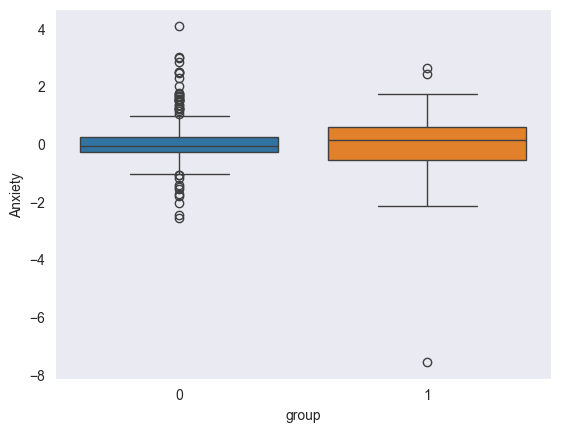

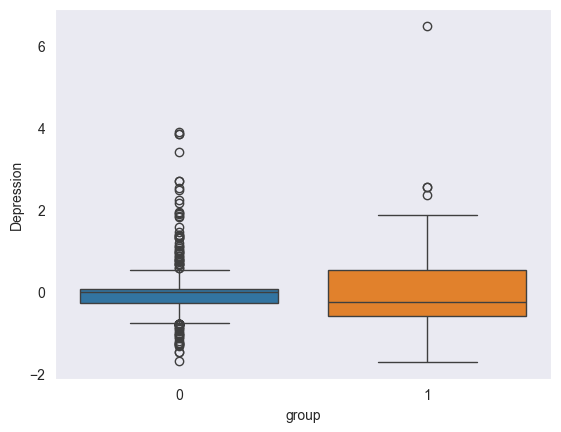

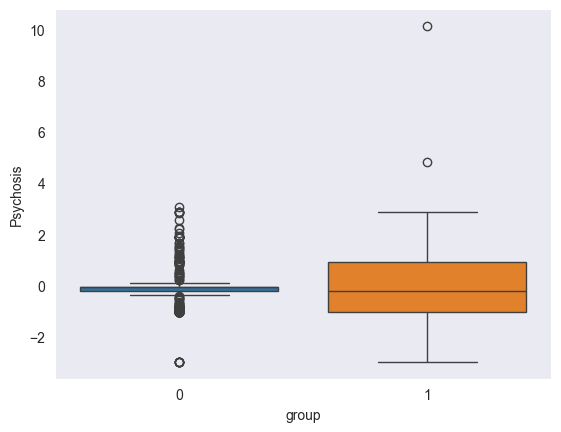

In [116]:
for val in ['Anxiety', 'Depression', "Psychosis"]:
    plot = sns.boxplot(data=clustering_df, x='group', y=val, hue='group')
    plot.get_legend().remove()
    plt.show()